In [1]:
from obspy import read, read_events, read_inventory
import os
import sys
from glob import glob
from obspy.signal.trigger import recursive_sta_lta
from obspy.signal.trigger import coincidence_trigger
from obspy.core.event.catalog import Catalog
from obspy.core.event.event import Event
from obspy.core.event.magnitude import StationMagnitude, Magnitude, StationMagnitudeContribution, Amplitude
from obspy.core.event.base import QuantityError, TimeWindow, WaveformStreamID, Comment
from helper_functions import *
%matplotlib inline

In [2]:
def get_stream(ev):

    starttime = min([p.time for p in ev.picks]) - 1.0
    endtime = min([p.time for p in ev.picks]) + 2.0
    stations = list(set([p.waveform_id.station_code for p in ev.picks]))
    DATA_DIR_ROOT = "/home/gilbert_lab/cami_frs/borehole_data/sac_daily_nez_500Hz/"
    datestr = "20200310"

    stream = read(os.path.join(os.path.join(DATA_DIR_ROOT, datestr), "*.sac"), starttime=starttime, endtime=endtime)
    stream.detrend("demean")
    stream.detrend("linear")
    
    return stream



In [3]:
cat = read_events("detections/20200310/bhdetections_20200310_*.xml")
catm = Catalog()
for ev in cat:
    if len(ev.magnitudes):
        catm += ev
        
print(catm)

34 Event(s) in Catalog:
 | -2.2129028140039715 Mw_spectral
 | -3.2416876991087893 Mw_time
...
 | -2.604842760464418 Mw_time
 | -2.9840448752351674 Mw_spectral
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [6]:
def magnitude(station, st, event):

    r_med = distance_from_tstp(event.picks, min_estim=1)
    print("median r = %.2f" % r_med)
    sta_st = st.select(station=station).copy()
    sta_st.detrend()
    #sta_st.plot()

    sta_picks = [p for p in event.picks if p.waveform_id.station_code == station]

    # Estimate coda
    tp = get_pick(event.picks, station, "P")
    ts = get_pick(event.picks, station, "S")
    if not ts:
        return
    if not tp:
        tsig = ts - 0.5
    else:
        tsig = tp - 0.02
    tcoda, s_len, snr = get_coda_duration(sta_st.copy(), tsig=tsig, ts=ts, win_len_s=0.2)

    # Estimate hypocentral distance from ts-tp
    VP = 1800.  # m/s
    VS = 630.  # m/s
    if ts and tp:
        r = (ts - tp) / (1 / VS - 1 / VP)
    else: 
        r = r_med
    print("Hypocentral distance: r = %.2f" % r)

    # Estimate Mw for each component
    Mw_spec_sta = []
    Mw_time_sta = []
    Q_spec_sta = []
    fc_spec_sta = []
    for tr in sta_st:
        print(tr.id)
        
        # Cut noise window and S waveform
        tr0 = tr.copy()
        noise_len = s_len
        taper_perc = 0.1
        trnoise = tr.copy()
        trnoise.trim(starttime=tsig - (1 + taper_perc) * noise_len, endtime=tsig - taper_perc * noise_len)
        trnoise.taper(type="hann", max_percentage=taper_perc, side="both")
        tr.trim(starttime=ts - taper_perc * s_len, endtime=ts + (1 + taper_perc) * s_len)
        tr.taper(type="hann", max_percentage=taper_perc, side="both")
        
        # Check SNR
        snr_trace = np.median(tr.slice(starttime=ts, endtime=ts + s_len).data) / \
                    np.median(trnoise.data)

        if snr_trace < 3:
            Logger.info("SNR < 3, skipping trace for magnitude calculation.")
            # Poor SNR, skip trace
            continue

        # Displacement waveform
        trdisp = tr.copy()
        trdisp.integrate()
        trdisp.detrend()

        # Estimate magnitude: time method
        Mw_time, M0_time, omega0_time = estimate_magnitude_time(trdisp, r, disp=True)
        Mw_time_sta.append(Mw_time)
        print("Mw time estimate: %.2f" % Mw_time)
        
        # plot
        ax = plt.subplot(111)
        tvec0 = tr0.times("matplotlib")
        tvec1 = tr.times("matplotlib")
        ax.plot_date(tvec0, tr0.data, "k")
        ax.plot_date(tvec1, tr.data, "r")
        dateFmt = mdates.DateFormatter('%H:%M:%S')
        ax.xaxis.set_major_formatter(dateFmt)
        plt.xticks(rotation=90)
        plt.title("%s: Mw time estimate = %.2f" % (tr.id, Mw_time))
        plt.show()
        plt.close()
        
        # Estimate magnitude: spectral method
        Mw_o, M0_o, omega0_o, fc_o, Q_o = estimate_magnitude_spectral(trdisp, r, omega0_time, trnoise=None,
                                                                      disp=True)
        if not Mw_o:
            Logger.warning("No magnitude found due to errors.")
            continue
        elif fc_o < 2 or Q_o > 40 or Q_o < 1:  # Qs Attenuation larger than Sandstone=31, shale=10
            # Reject spectral estimate
            Logger.warning("Rejecting spectral estimate with: fc = %f, Q = %f" % (fc_o, Q_o))
            continue
        else:
            Mw_spec_sta.append(Mw_o)
            Q_spec_sta.append(Q_o)
            fc_spec_sta.append(fc_o)
            print("Mw = %.2f, Q = %.2f, Fc = %.1f" % (Mw_o, Q_o, fc_o))
            
    return Mw_spec_sta, Mw_time_sta, Q_spec_sta, fc_spec_sta

Event:	 | -2.374314636492673 Mw_spectral

	        resource_id: ResourceIdentifier(id="smi:local/15c6451b-dd46-4d2a-ae5f-8dc60e7a6988")
	               ---------
	              picks: 20 Elements
	         amplitudes: 20 Elements
	         magnitudes: 2 Elements
	 station_magnitudes: 10 Elements
station: G8
median r = 311.40
Hypocentral distance: r = 313.70
BH.G8..DPE
BH.G8..DPN
BH.G8..DPZ
station: G13
median r = 311.40
Hypocentral distance: r = 309.33
BH.G13..DPE
BH.G13..DPN
BH.G13..DPZ
station: G2
median r = 311.40
Hypocentral distance: r = 317.86
BH.G2..DPE
BH.G2..DPN
BH.G2..DPZ
station: G14
median r = 311.40
Hypocentral distance: r = 302.39
BH.G14..DPE
BH.G14..DPN
BH.G14..DPZ
Mw time estimate: -2.63


/home/genevieve.savard/anaconda3/envs/eqcorrscan/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in float_scalars


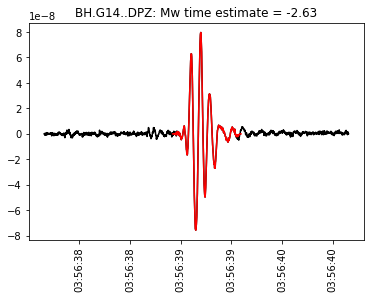

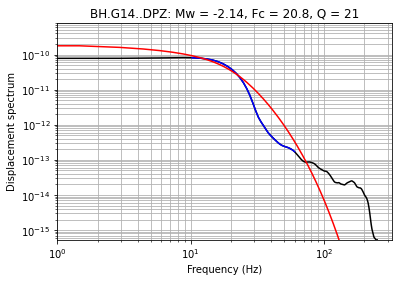

Mw = -2.14, Q = 21.22, Fc = 20.8
station: G15
median r = 311.40
Hypocentral distance: r = 310.44
BH.G15..DPE
BH.G15..DPN
BH.G15..DPZ
station: G6
median r = 311.40
Hypocentral distance: r = 315.03
BH.G6..DPE
BH.G6..DPN
Mw time estimate: -2.81


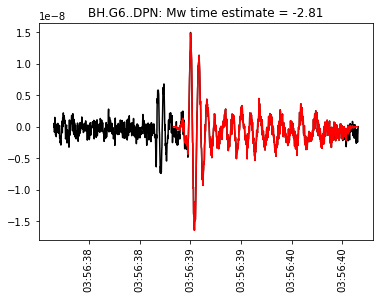

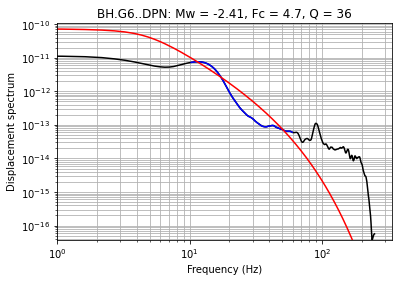

Mw = -2.41, Q = 36.41, Fc = 4.7
BH.G6..DPZ
station: G17
median r = 311.40
Hypocentral distance: r = 311.40
BH.G17..DPE
BH.G17..DPN
BH.G17..DPZ
station: G1
median r = 311.40
Hypocentral distance: r = 311.76
BH.G1..DPE
BH.G1..DPN
BH.G1..DPZ
station: G11
median r = 311.40
Hypocentral distance: r = 309.63
BH.G11..DPE
Mw time estimate: -2.88


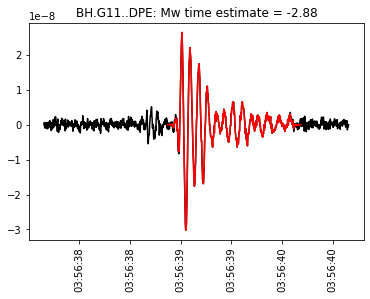

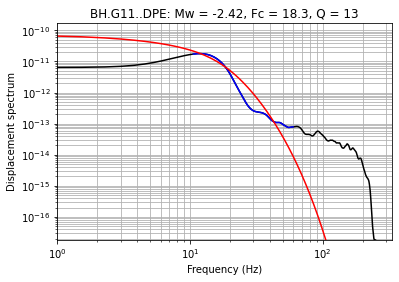

Mw = -2.42, Q = 13.92, Fc = 18.3
BH.G11..DPN
Mw time estimate: -3.11


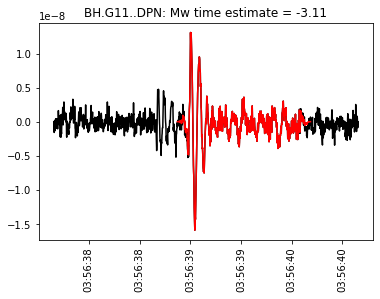

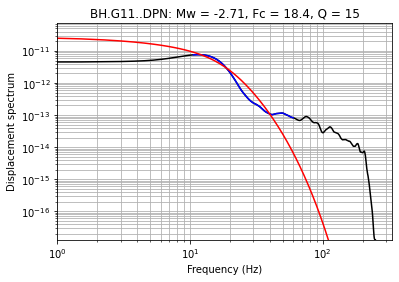

Mw = -2.71, Q = 15.52, Fc = 18.4
BH.G11..DPZ
station: G18
median r = 311.40
Hypocentral distance: r = 311.40
BH.G18..DPE
BH.G18..DPN
BH.G18..DPZ
station: G12
median r = 311.40
Hypocentral distance: r = 311.40
BH.G12..DPE
BH.G12..DPN
BH.G12..DPZ
Mw time estimate: -2.46


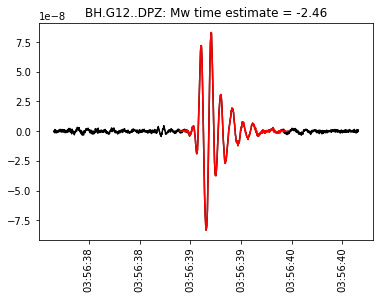

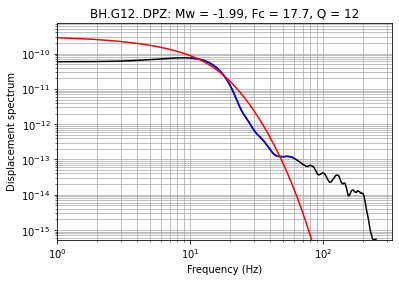

Mw = -1.99, Q = 12.41, Fc = 17.7
Event:	 | -2.1941394037546655 Mw_spectral

	        resource_id: ResourceIdentifier(id="smi:local/3d126faf-0384-4555-9e81-059e1d04aefb")
	               ---------
	              picks: 22 Elements
	         amplitudes: 22 Elements
	         magnitudes: 2 Elements
	 station_magnitudes: 10 Elements
station: G8
median r = 272.74
Hypocentral distance: r = 272.74
BH.G8..DPE
BH.G8..DPN
BH.G8..DPZ
station: G13
median r = 272.74
Hypocentral distance: r = 273.20
BH.G13..DPE
BH.G13..DPN
BH.G13..DPZ
station: G2
median r = 272.74
Hypocentral distance: r = 273.90
BH.G2..DPE
BH.G2..DPN
BH.G2..DPZ
station: G14
median r = 272.74
Hypocentral distance: r = 269.32
BH.G14..DPE
BH.G14..DPN
BH.G14..DPZ
station: G15
median r = 272.74
Hypocentral distance: r = 275.83
BH.G15..DPE
BH.G15..DPN
Mw time estimate: -2.79


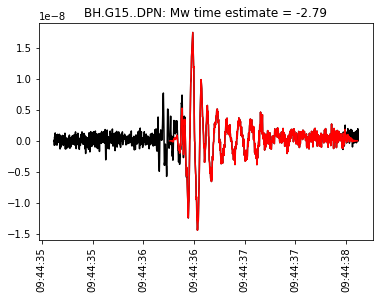

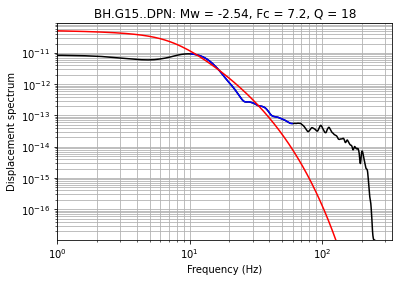

Mw = -2.54, Q = 18.02, Fc = 7.2
BH.G15..DPZ
station: G6
median r = 272.74
Hypocentral distance: r = 271.49
BH.G6..DPE
BH.G6..DPN
Mw time estimate: -2.68


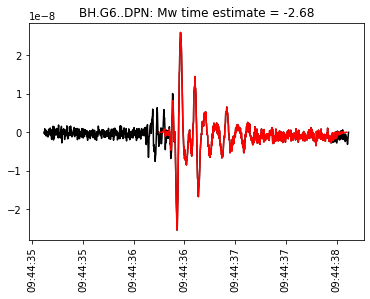

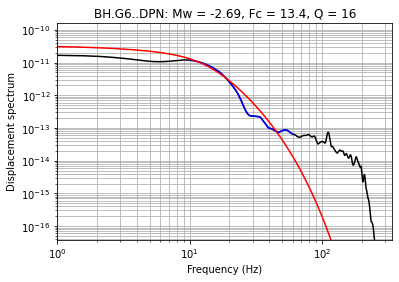

Mw = -2.69, Q = 16.95, Fc = 13.4
BH.G6..DPZ
station: G17
median r = 272.74
Hypocentral distance: r = 271.39
BH.G17..DPE
Mw time estimate: -2.37


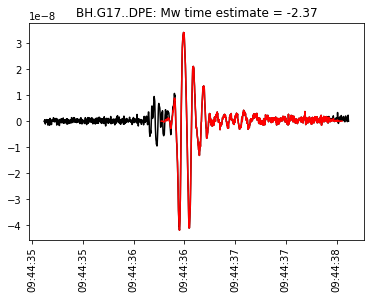

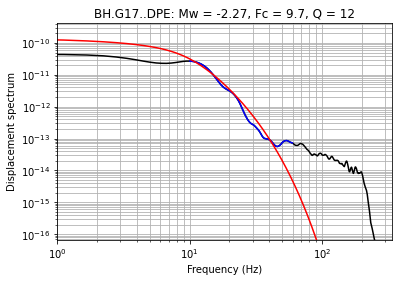

Mw = -2.27, Q = 12.18, Fc = 9.7
BH.G17..DPN
Mw time estimate: -2.55


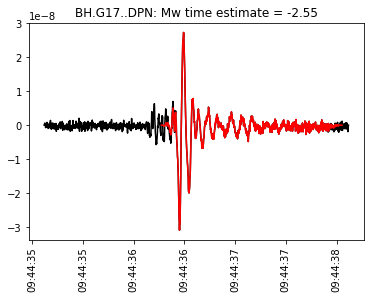

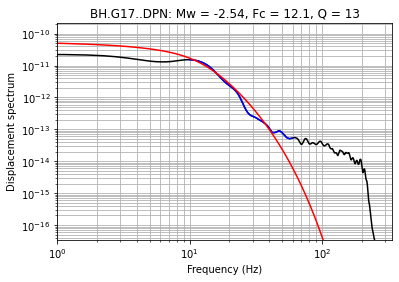

Mw = -2.54, Q = 13.75, Fc = 12.1
BH.G17..DPZ
station: G1
median r = 272.74
Hypocentral distance: r = 269.55
BH.G1..DPE
BH.G1..DPN
BH.G1..DPZ
Mw time estimate: -2.26


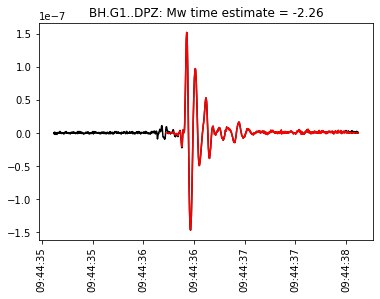

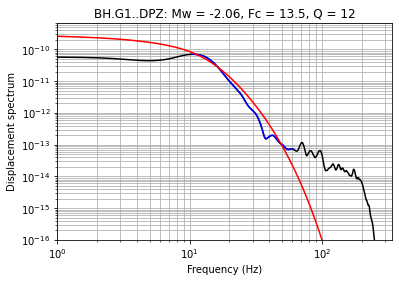

Mw = -2.06, Q = 12.41, Fc = 13.5
station: G11
median r = 272.74
Hypocentral distance: r = 273.42
BH.G11..DPE
BH.G11..DPN
BH.G11..DPZ
station: G18
median r = 272.74
Hypocentral distance: r = 272.57
BH.G18..DPE
Mw time estimate: -2.28


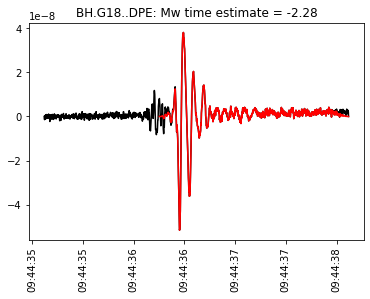

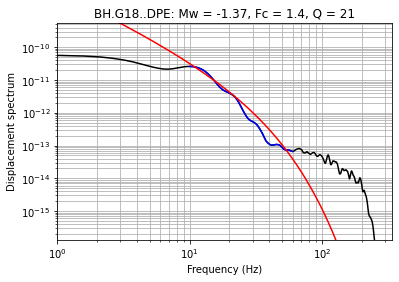

Rejecting spectral estimate with: fc = 1.365597, Q = 21.878263


BH.G18..DPN
BH.G18..DPZ
Mw time estimate: -2.12


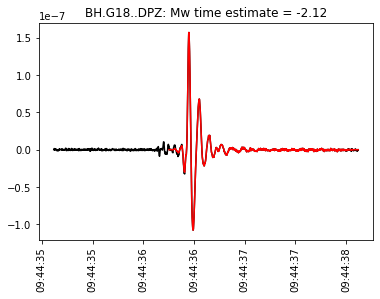

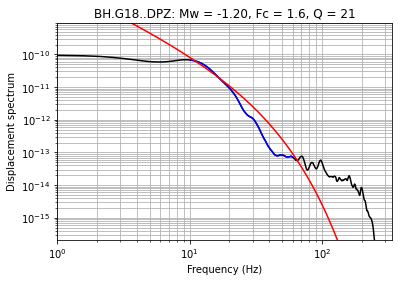

Rejecting spectral estimate with: fc = 1.640689, Q = 21.306375


station: G12
median r = 272.74
Hypocentral distance: r = 273.46
BH.G12..DPE
BH.G12..DPN
BH.G12..DPZ
Event:	 | -3.293782165972419 Mw_spectral

	        resource_id: ResourceIdentifier(id="smi:local/dac1ddca-97ae-4ab2-9f71-73d914c0e33a")
	               ---------
	              picks: 10 Elements
	         amplitudes: 10 Elements
	         magnitudes: 2 Elements
	 station_magnitudes: 7 Elements
station: G8
median r = 203.32
Hypocentral distance: r = 203.32
BH.G8..DPE
BH.G8..DPN
BH.G8..DPZ
station: G2
median r = 203.32
Hypocentral distance: r = 203.32
BH.G2..DPE
BH.G2..DPN
BH.G2..DPZ
station: G14
median r = 203.32
Hypocentral distance: r = 203.32
BH.G14..DPE
BH.G14..DPN
BH.G14..DPZ
station: G15
median r = 203.32
Hypocentral distance: r = 203.32
BH.G15..DPE
BH.G15..DPN
BH.G15..DPZ
station: G6
median r = 203.32
Hypocentral distance: r = 203.32
BH.G6..DPE
BH.G6..DPN
BH.G6..DPZ
station: G17
median r = 203.32
Hypocentral distance: r = 203.32
BH.G17..DPE
BH.G17..DPN
BH.G17..DPZ
station: G1
medi

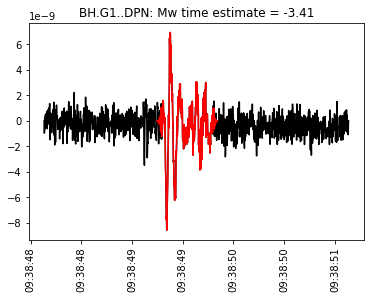

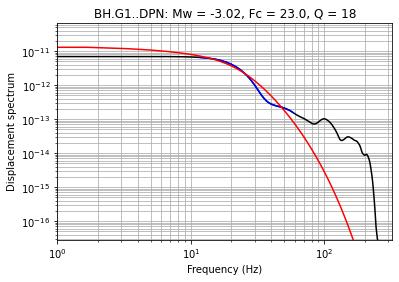

Mw = -3.02, Q = 18.05, Fc = 23.0
BH.G1..DPZ
station: G11
median r = 203.32
Hypocentral distance: r = 203.32
BH.G11..DPE
BH.G11..DPN
BH.G11..DPZ
station: G12
median r = 203.32
Hypocentral distance: r = 203.32
BH.G12..DPE
BH.G12..DPN
BH.G12..DPZ
Event:	 | -2.5070516417191 Mw_spectral

	        resource_id: ResourceIdentifier(id="smi:local/471fa928-1790-45dd-908d-6e9687a15ffa")
	               ---------
	              picks: 18 Elements
	         amplitudes: 18 Elements
	         magnitudes: 2 Elements
	 station_magnitudes: 6 Elements
station: G8
median r = 235.92
Hypocentral distance: r = 233.93
BH.G8..DPE
Mw time estimate: -2.61


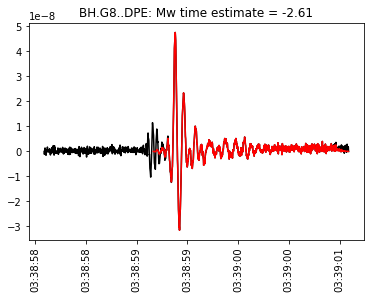

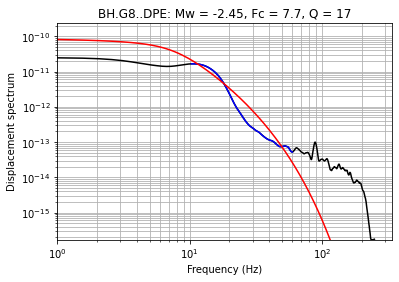

Mw = -2.45, Q = 17.43, Fc = 7.7
BH.G8..DPN
BH.G8..DPZ
station: G13
median r = 235.92
Hypocentral distance: r = 235.92
BH.G13..DPE
BH.G13..DPN
Mw time estimate: -2.59


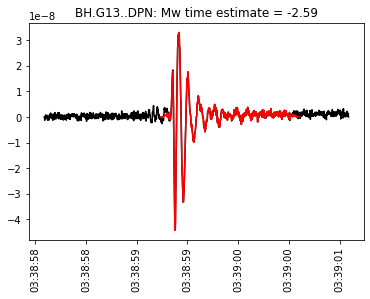

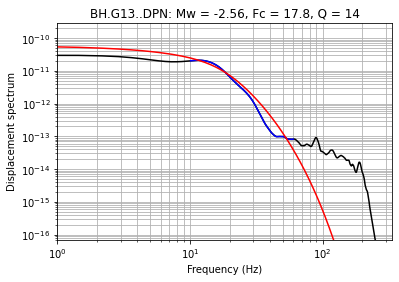

Mw = -2.56, Q = 14.48, Fc = 17.8
BH.G13..DPZ
station: G2
median r = 235.92
Hypocentral distance: r = 237.27
BH.G2..DPE
Mw time estimate: -2.53


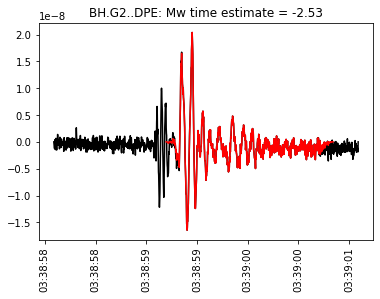

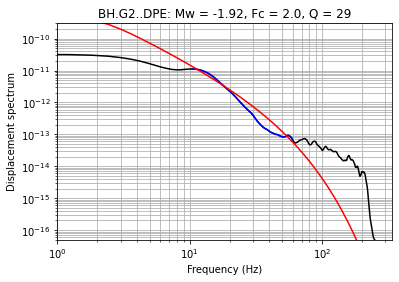

Mw = -1.92, Q = 29.74, Fc = 2.0
BH.G2..DPN
BH.G2..DPZ
station: G14
median r = 235.92
Hypocentral distance: r = 235.92
BH.G14..DPE
BH.G14..DPN
Mw time estimate: -2.69


/home/genevieve.savard/anaconda3/envs/eqcorrscan/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in float_scalars


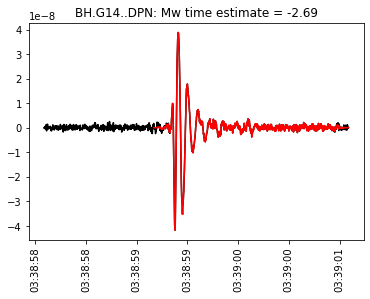

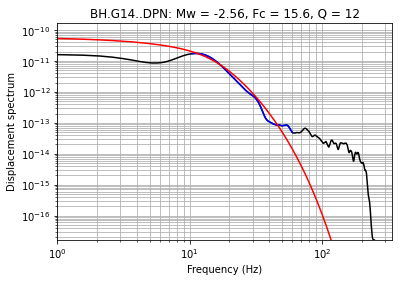

Mw = -2.56, Q = 12.50, Fc = 15.6
BH.G14..DPZ
station: G15
median r = 235.92
Hypocentral distance: r = 235.92
BH.G15..DPE
BH.G15..DPN
BH.G15..DPZ
station: G6
median r = 235.92
Hypocentral distance: r = 233.75
BH.G6..DPE
BH.G6..DPN
BH.G6..DPZ
Mw time estimate: -2.51


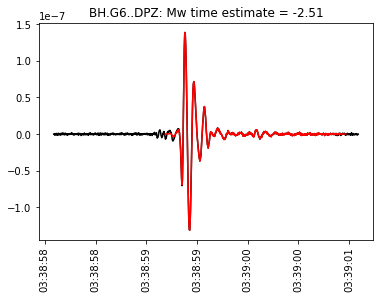

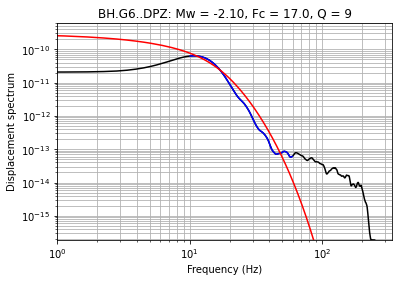

Mw = -2.10, Q = 9.15, Fc = 17.0
station: G17
median r = 235.92
Hypocentral distance: r = 239.70
BH.G17..DPE
BH.G17..DPN
BH.G17..DPZ
station: G1
median r = 235.92
Hypocentral distance: r = 231.28
BH.G1..DPE
Mw time estimate: -2.46


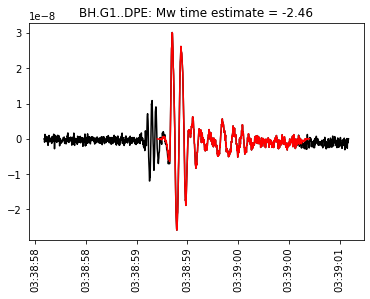

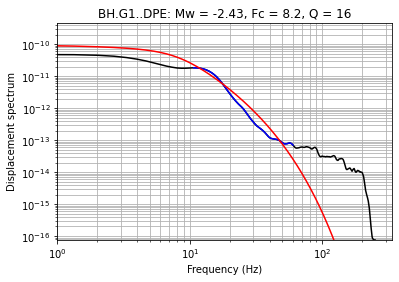

Mw = -2.43, Q = 16.30, Fc = 8.2
BH.G1..DPN
Mw time estimate: -2.50


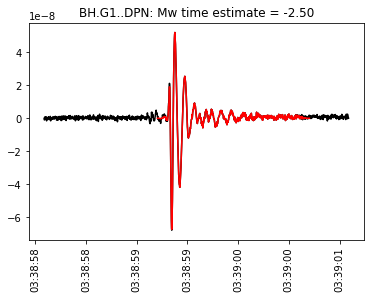

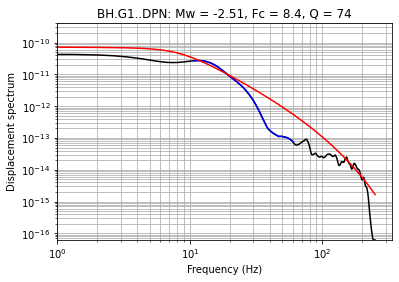

Rejecting spectral estimate with: fc = 8.361710, Q = 74.175923


BH.G1..DPZ
Mw time estimate: -2.32


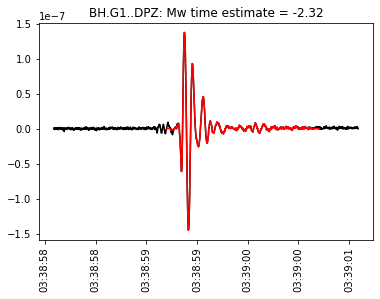

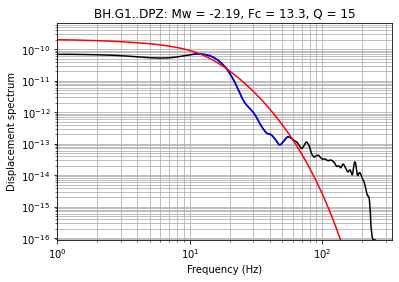

Mw = -2.19, Q = 15.71, Fc = 13.3
station: G11
median r = 235.92
Hypocentral distance: r = 235.92
BH.G11..DPE
BH.G11..DPN
BH.G11..DPZ
Mw time estimate: -2.57


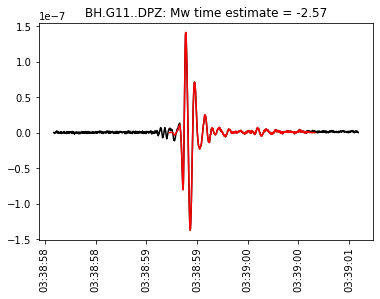

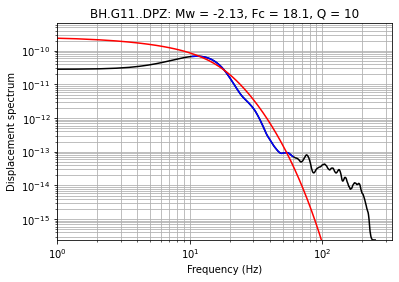

Mw = -2.13, Q = 10.97, Fc = 18.1
station: G18
median r = 235.92
Hypocentral distance: r = 235.92
BH.G18..DPE
BH.G18..DPN
BH.G18..DPZ
station: G12
median r = 235.92
Hypocentral distance: r = 241.66
BH.G12..DPE
BH.G12..DPN
BH.G12..DPZ
Event:	 | -2.838931266363469 Mw_spectral

	        resource_id: ResourceIdentifier(id="smi:local/143dc240-5f59-45ce-ae18-fe2d544f38b8")
	               ---------
	              picks: 14 Elements
	         amplitudes: 14 Elements
	         magnitudes: 2 Elements
	 station_magnitudes: 6 Elements
station: G8
median r = 247.54
Hypocentral distance: r = 224.91
BH.G8..DPE
BH.G8..DPN
BH.G8..DPZ
station: G13
median r = 247.54
Hypocentral distance: r = 247.54
BH.G13..DPE
Mw time estimate: -2.99


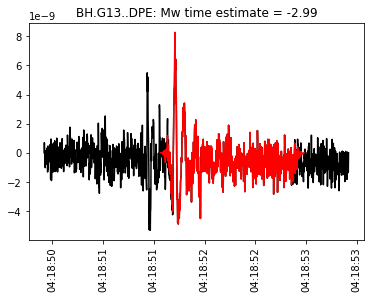

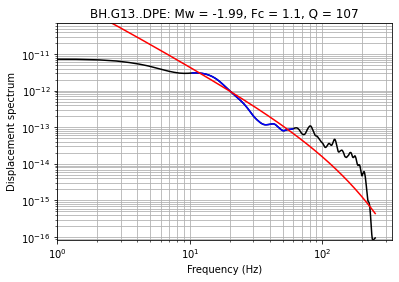

Rejecting spectral estimate with: fc = 1.099478, Q = 107.011578


BH.G13..DPN
BH.G13..DPZ
station: G2
median r = 247.54
Hypocentral distance: r = 247.54
BH.G2..DPE
BH.G2..DPN
BH.G2..DPZ
station: G14
median r = 247.54
Hypocentral distance: r = 247.54
BH.G14..DPE
BH.G14..DPN
BH.G14..DPZ
station: G15
median r = 247.54
Hypocentral distance: r = 247.54
BH.G15..DPE
BH.G15..DPN
BH.G15..DPZ
station: G6
median r = 247.54
Hypocentral distance: r = 247.54
BH.G6..DPE
BH.G6..DPN
BH.G6..DPZ
station: G17
median r = 247.54
Hypocentral distance: r = 247.54
BH.G17..DPE
BH.G17..DPN
Mw time estimate: -2.98


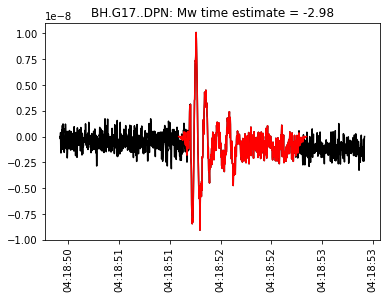

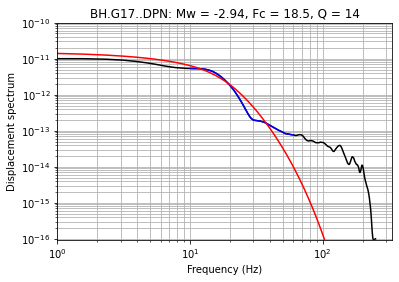

Mw = -2.94, Q = 14.91, Fc = 18.5
BH.G17..DPZ
station: G1
median r = 247.54
Hypocentral distance: r = 247.54
BH.G1..DPE
BH.G1..DPN
Mw time estimate: -3.18


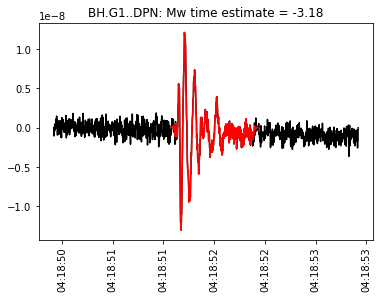

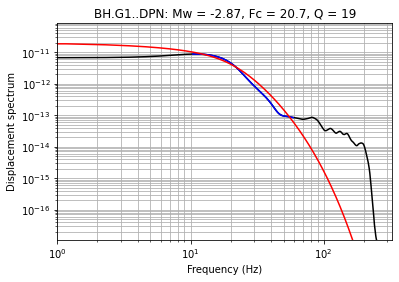

Mw = -2.87, Q = 19.86, Fc = 20.7
BH.G1..DPZ
station: G11
median r = 247.54
Hypocentral distance: r = 247.54
BH.G11..DPE
Mw time estimate: -3.43


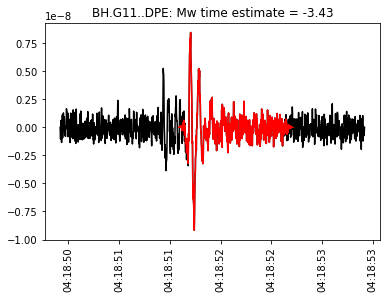

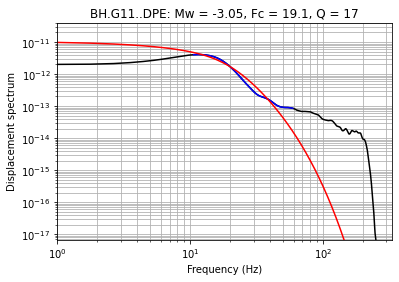

Mw = -3.05, Q = 17.37, Fc = 19.1
BH.G11..DPN
BH.G11..DPZ
station: G18
median r = 247.54
Hypocentral distance: r = 251.01
BH.G18..DPE
BH.G18..DPN
BH.G18..DPZ
station: G12
median r = 247.54
Hypocentral distance: r = 247.54
BH.G12..DPE
BH.G12..DPN
BH.G12..DPZ
Event:	 | -2.3919366045487673 Mw_spectral

	        resource_id: ResourceIdentifier(id="smi:local/6188f5a0-a161-490e-9294-a78ce5af467b")
	               ---------
	              picks: 14 Elements
	         amplitudes: 14 Elements
	         magnitudes: 2 Elements
	 station_magnitudes: 6 Elements
station: G8
median r = 327.64
Hypocentral distance: r = 327.64
BH.G8..DPE
BH.G8..DPN
BH.G8..DPZ
station: G13
median r = 327.64
Hypocentral distance: r = 327.64
BH.G13..DPE
BH.G13..DPN
BH.G13..DPZ
station: G2
median r = 327.64
Hypocentral distance: r = 327.64
BH.G2..DPE
BH.G2..DPN
BH.G2..DPZ
station: G14
median r = 327.64
Hypocentral distance: r = 327.64
BH.G14..DPE
BH.G14..DPN
BH.G14..DPZ
station: G15
median r = 327.64
Hypocentral distance: r

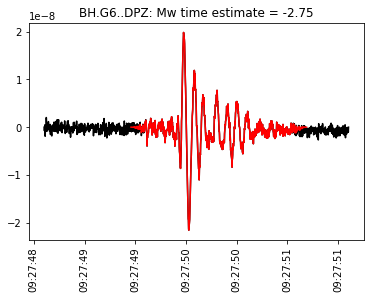

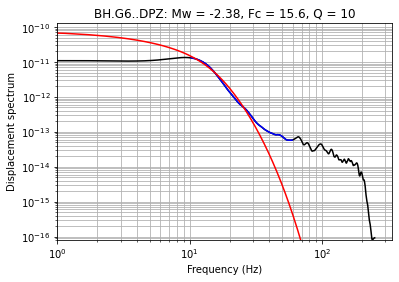

Mw = -2.38, Q = 10.40, Fc = 15.6
station: G17
median r = 327.64
Hypocentral distance: r = 326.96
BH.G17..DPE
BH.G17..DPN
BH.G17..DPZ
station: G1
median r = 327.64
Hypocentral distance: r = 327.64
BH.G1..DPE
BH.G1..DPN
BH.G1..DPZ
Mw time estimate: -2.59


/home/genevieve.savard/anaconda3/envs/eqcorrscan/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in float_scalars


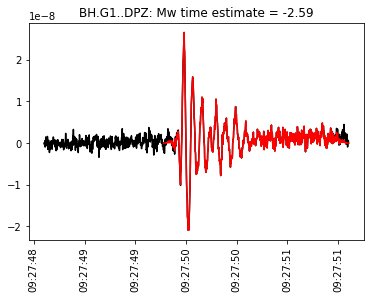

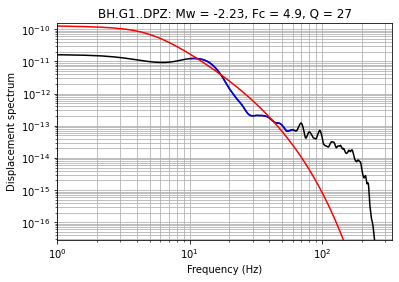

Mw = -2.23, Q = 27.64, Fc = 4.9
station: G11
median r = 327.64
Hypocentral distance: r = 327.64
BH.G11..DPE
BH.G11..DPN
BH.G11..DPZ
station: G18
median r = 327.64
Hypocentral distance: r = 327.64
BH.G18..DPE
Mw time estimate: -2.84


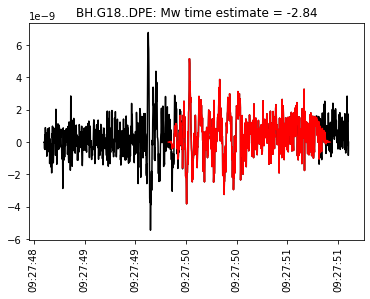

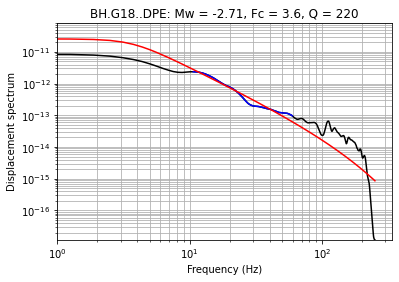

Rejecting spectral estimate with: fc = 3.642843, Q = 220.603784


BH.G18..DPN
BH.G18..DPZ
station: G12
median r = 327.64
Hypocentral distance: r = 327.64
BH.G12..DPE
BH.G12..DPN
BH.G12..DPZ
Event:	 | -2.275942125554054 Mw_spectral

	        resource_id: ResourceIdentifier(id="smi:local/768f8440-98bc-4905-a13b-92535ba1175b")
	               ---------
	              picks: 17 Elements
	         amplitudes: 17 Elements
	         magnitudes: 2 Elements
	 station_magnitudes: 6 Elements
station: G8
median r = 259.87
Hypocentral distance: r = 258.29
BH.G8..DPE
BH.G8..DPN
BH.G8..DPZ
station: G13
median r = 259.87
Hypocentral distance: r = 259.87
BH.G13..DPE
BH.G13..DPN
BH.G13..DPZ
station: G2
median r = 259.87
Hypocentral distance: r = 260.69
BH.G2..DPE
BH.G2..DPN
BH.G2..DPZ
station: G14
median r = 259.87
Hypocentral distance: r = 262.24
BH.G14..DPE
BH.G14..DPN
BH.G14..DPZ
station: G15
median r = 259.87
Hypocentral distance: r = 259.87
BH.G15..DPE
BH.G15..DPN
BH.G15..DPZ
station: G6
median r = 259.87
Hypocentral distance: r = 259.05
BH.G6..DPE
Mw time estima

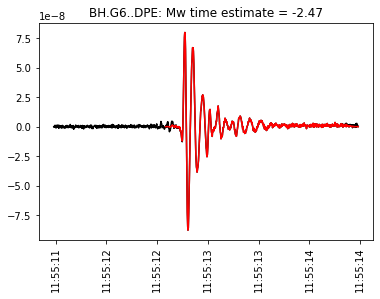

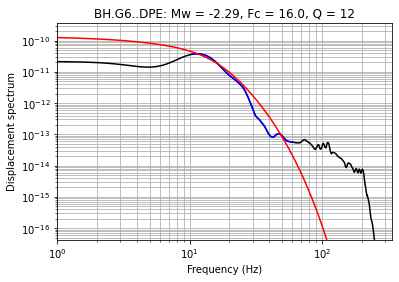

Mw = -2.29, Q = 12.63, Fc = 16.0
BH.G6..DPN
BH.G6..DPZ
station: G17
median r = 259.87
Hypocentral distance: r = 259.87
BH.G17..DPE
BH.G17..DPN
Mw time estimate: -2.36


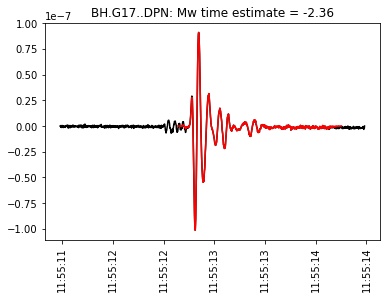

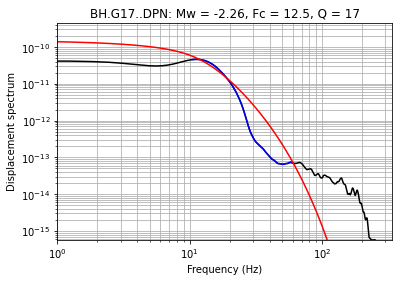

Mw = -2.26, Q = 17.35, Fc = 12.5
BH.G17..DPZ
station: G1
median r = 259.87
Hypocentral distance: r = 258.50
BH.G1..DPE
BH.G1..DPN
BH.G1..DPZ
Mw time estimate: -2.21


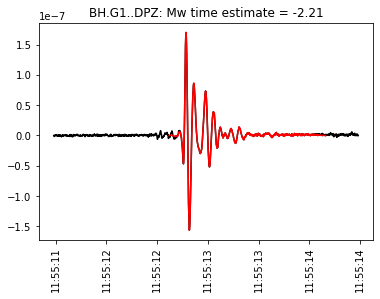

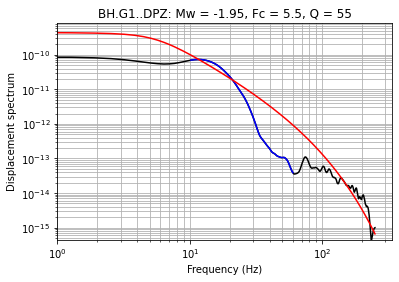

Rejecting spectral estimate with: fc = 5.480794, Q = 55.717465


station: G11
median r = 259.87
Hypocentral distance: r = 259.87
BH.G11..DPE
BH.G11..DPN
BH.G11..DPZ
station: G18
median r = 259.87
Hypocentral distance: r = 259.87
BH.G18..DPE
BH.G18..DPN
BH.G18..DPZ
station: G12
median r = 259.87
Hypocentral distance: r = 263.68
BH.G12..DPE
BH.G12..DPN
BH.G12..DPZ
Event:	 | -2.6740912732560487 Mw_spectral

	        resource_id: ResourceIdentifier(id="smi:local/0f8cf4cf-2a1f-47bd-b0f2-5e76d248ae10")
	               ---------
	              picks: 13 Elements
	         amplitudes: 13 Elements
	         magnitudes: 2 Elements
	 station_magnitudes: 5 Elements
station: G8
median r = 313.22
Hypocentral distance: r = 313.22
BH.G8..DPE
BH.G8..DPN
BH.G8..DPZ
station: G13
median r = 313.22
Hypocentral distance: r = 313.22
BH.G13..DPE
Mw time estimate: -2.76


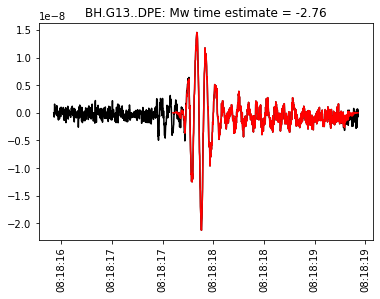

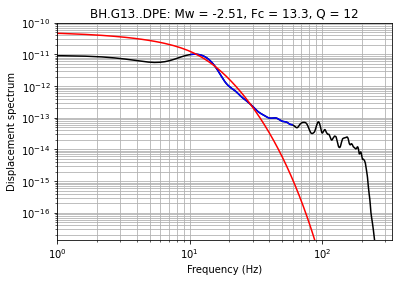

Mw = -2.51, Q = 12.11, Fc = 13.3
BH.G13..DPN
BH.G13..DPZ
station: G14
median r = 313.22
Hypocentral distance: r = 313.22
BH.G14..DPE
BH.G14..DPN
BH.G14..DPZ
station: G15
median r = 313.22
Hypocentral distance: r = 313.22
BH.G15..DPE
BH.G15..DPN
BH.G15..DPZ
Mw time estimate: -2.25


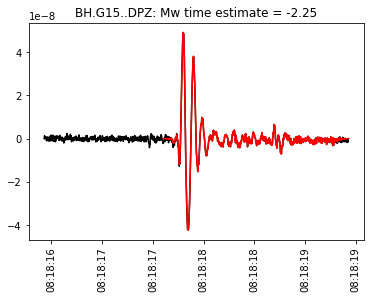

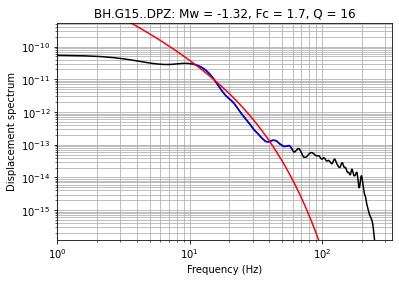

Rejecting spectral estimate with: fc = 1.742564, Q = 16.191338


station: G6
median r = 313.22
Hypocentral distance: r = 313.22
BH.G6..DPE
Mw time estimate: -2.51


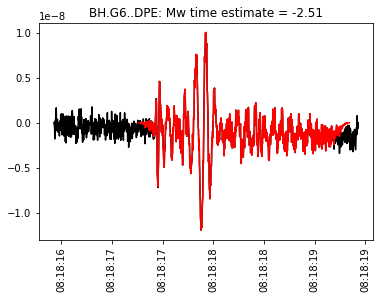

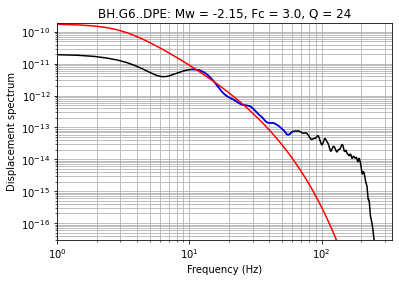

Mw = -2.15, Q = 24.83, Fc = 3.0
BH.G6..DPN
BH.G6..DPZ
station: G17
median r = 313.22
Hypocentral distance: r = 313.22
BH.G17..DPE
BH.G17..DPN
BH.G17..DPZ
station: G1
median r = 313.22
Hypocentral distance: r = 316.99
BH.G1..DPE
BH.G1..DPN
BH.G1..DPZ
station: G11
median r = 313.22
Hypocentral distance: r = 311.94
BH.G11..DPE
Mw time estimate: -2.69


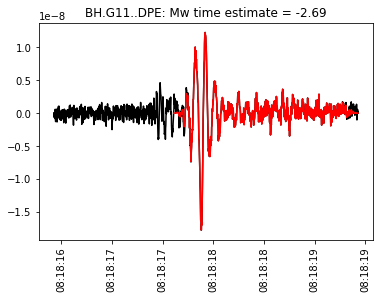

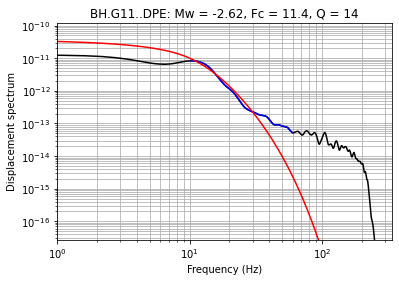

Mw = -2.62, Q = 14.80, Fc = 11.4
BH.G11..DPN
BH.G11..DPZ
station: G18
median r = 313.22
Hypocentral distance: r = 313.22
BH.G18..DPE
BH.G18..DPN
BH.G18..DPZ
station: G12
median r = 313.22
Hypocentral distance: r = 313.22
BH.G12..DPE
BH.G12..DPN
BH.G12..DPZ
Event:	 | -2.622178149379211 Mw_spectral

	        resource_id: ResourceIdentifier(id="smi:local/c63b7da0-9f5b-49eb-8569-d1c348ac486e")
	               ---------
	              picks: 17 Elements
	         amplitudes: 15 Elements
	         magnitudes: 2 Elements
	 station_magnitudes: 4 Elements
station: G8
median r = 288.33
Hypocentral distance: r = 288.33
BH.G8..DPE
BH.G8..DPN
BH.G8..DPZ
Mw time estimate: -2.87


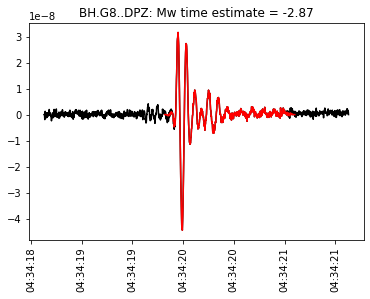

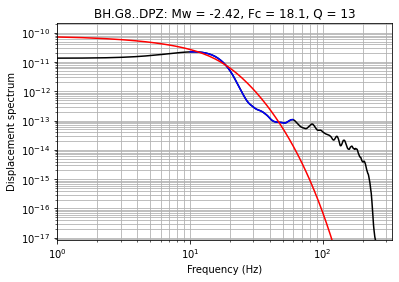

Mw = -2.42, Q = 13.72, Fc = 18.1
station: G13
median r = 288.33
Hypocentral distance: r = 288.07
BH.G13..DPE
BH.G13..DPN
BH.G13..DPZ
station: G2
median r = 288.33
Hypocentral distance: r = 288.33
BH.G2..DPE
BH.G2..DPN
Mw time estimate: -3.12


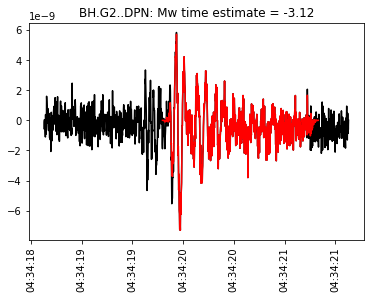

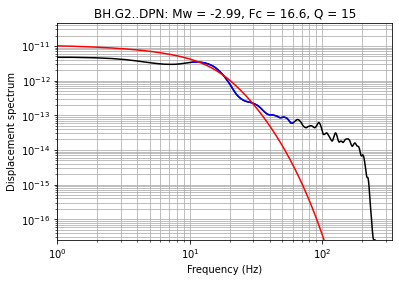

Mw = -2.99, Q = 15.85, Fc = 16.6
BH.G2..DPZ
Mw time estimate: -2.65


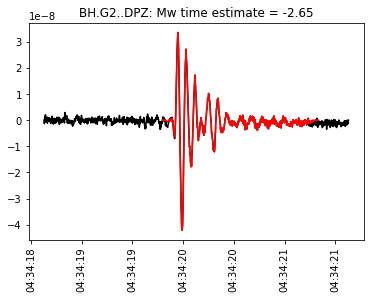

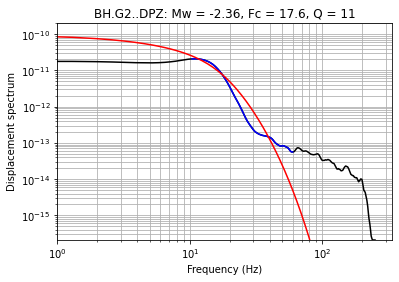

Mw = -2.36, Q = 11.57, Fc = 17.6
station: G14
median r = 288.33
Hypocentral distance: r = 285.01
BH.G14..DPE
Mw time estimate: -3.04


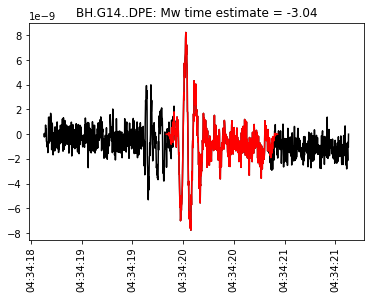

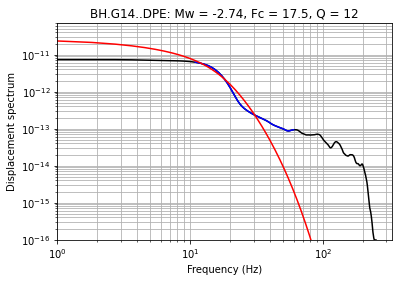

Mw = -2.74, Q = 12.20, Fc = 17.5
BH.G14..DPN
Mw time estimate: -3.23


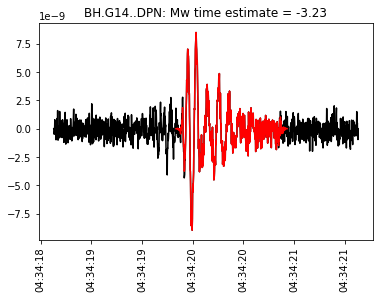

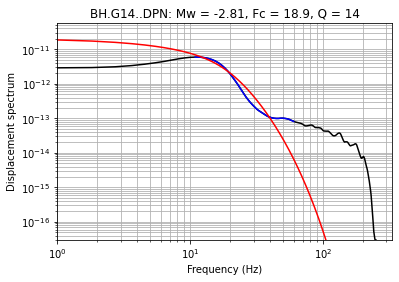

Mw = -2.81, Q = 14.91, Fc = 18.9
BH.G14..DPZ
Mw time estimate: -2.88


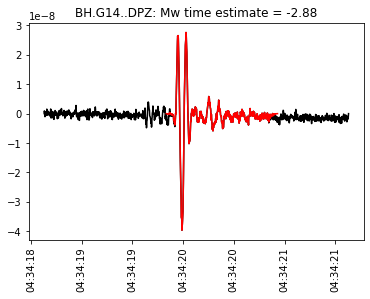

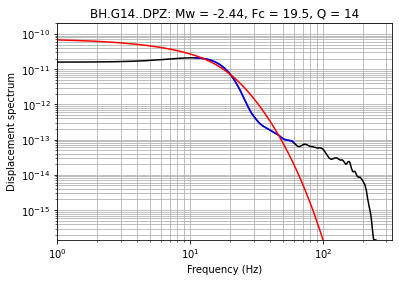

Mw = -2.44, Q = 14.32, Fc = 19.5
station: G15
median r = 288.33
Hypocentral distance: r = 289.62
BH.G15..DPE
Mw time estimate: -3.04


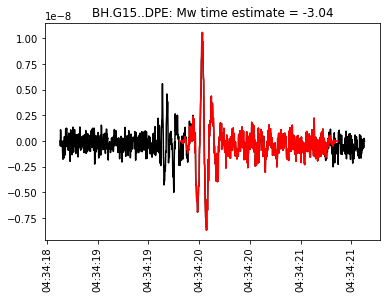

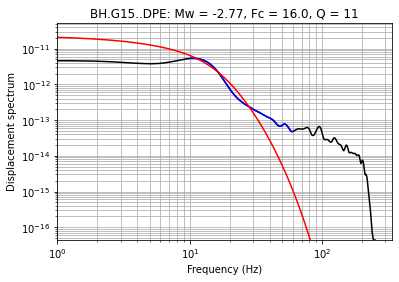

Mw = -2.77, Q = 11.79, Fc = 16.0
BH.G15..DPN
BH.G15..DPZ
station: G6
median r = 288.33
Hypocentral distance: r = 288.33
BH.G6..DPE
Mw time estimate: -3.04


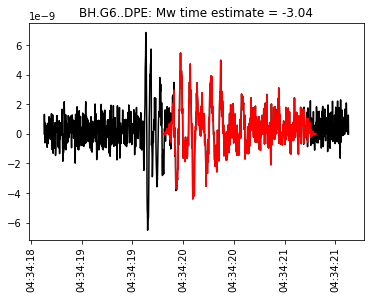

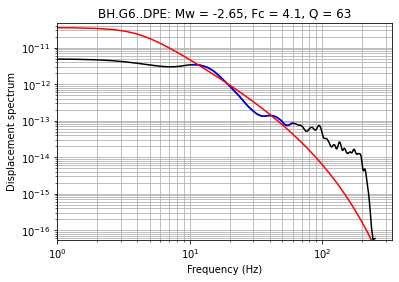

Rejecting spectral estimate with: fc = 4.051932, Q = 63.772627


BH.G6..DPN
BH.G6..DPZ
station: G17
median r = 288.33
Hypocentral distance: r = 288.33
BH.G17..DPE
BH.G17..DPN
BH.G17..DPZ
station: G1
median r = 288.33
Hypocentral distance: r = 288.33
BH.G1..DPE
BH.G1..DPN
BH.G1..DPZ
Mw time estimate: -2.57


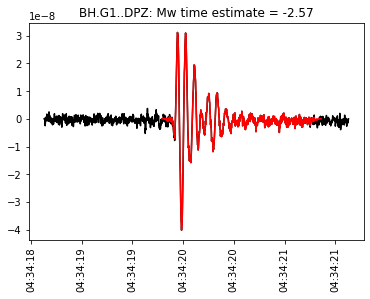

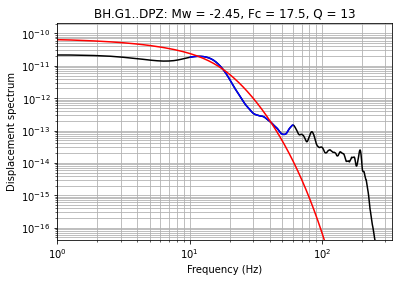

Mw = -2.45, Q = 13.79, Fc = 17.5
station: G11
median r = 288.33
Hypocentral distance: r = 288.58
BH.G11..DPE
BH.G11..DPN
BH.G11..DPZ
station: G18
median r = 288.33
Hypocentral distance: r = 291.78
BH.G18..DPE
BH.G18..DPN
BH.G18..DPZ
station: G12
median r = 288.33
Hypocentral distance: r = 288.08
BH.G12..DPE
BH.G12..DPN
BH.G12..DPZ
Event:	 | -2.5480124774516684 Mw_spectral

	        resource_id: ResourceIdentifier(id="smi:local/563ced25-e4a5-4e16-9a73-fbdfd254017f")
	               ---------
	              picks: 20 Elements
	         amplitudes: 20 Elements
	         magnitudes: 2 Elements
	 station_magnitudes: 4 Elements


/home/genevieve.savard/anaconda3/envs/eqcorrscan/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in float_scalars


station: G8
median r = 220.34
Hypocentral distance: r = 216.80
BH.G8..DPE
BH.G8..DPN
BH.G8..DPZ
station: G13
median r = 220.34
Hypocentral distance: r = 220.69
BH.G13..DPE
BH.G13..DPN
BH.G13..DPZ
station: G2
median r = 220.34
Hypocentral distance: r = 214.56
BH.G2..DPE
BH.G2..DPN
BH.G2..DPZ
station: G14
median r = 220.34
Hypocentral distance: r = 220.34
BH.G14..DPE
BH.G14..DPN
BH.G14..DPZ
station: G15
median r = 220.34
Hypocentral distance: r = 221.46
BH.G15..DPE
BH.G15..DPN
BH.G15..DPZ
station: G6
median r = 220.34
Hypocentral distance: r = 216.44
BH.G6..DPE
BH.G6..DPN
Mw time estimate: -3.04


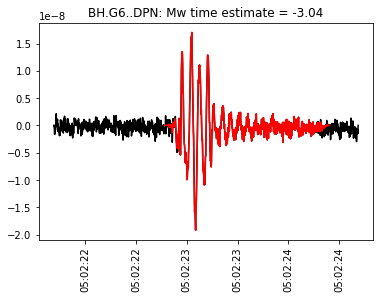

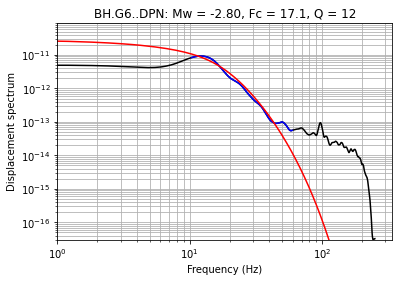

Mw = -2.80, Q = 12.16, Fc = 17.1
BH.G6..DPZ
station: G17
median r = 220.34
Hypocentral distance: r = 223.21
BH.G17..DPE
BH.G17..DPN
BH.G17..DPZ
station: G1
median r = 220.34
Hypocentral distance: r = 211.39
BH.G1..DPE
BH.G1..DPN
BH.G1..DPZ
station: G11
median r = 220.34
Hypocentral distance: r = 220.34
BH.G11..DPE
BH.G11..DPN
BH.G11..DPZ
station: G18
median r = 220.34
Hypocentral distance: r = 223.99
BH.G18..DPE
BH.G18..DPN
BH.G18..DPZ
station: G12
median r = 220.34
Hypocentral distance: r = 220.34
BH.G12..DPE
Mw time estimate: -2.66


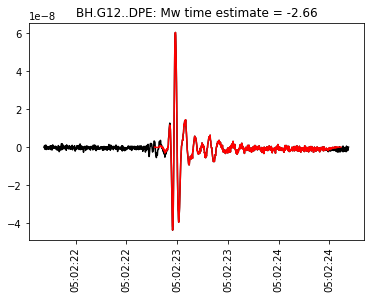

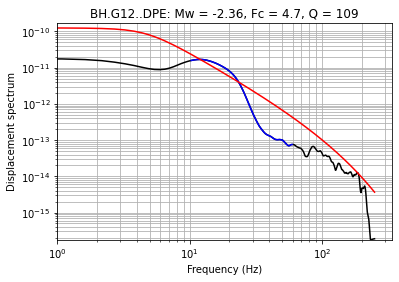

Rejecting spectral estimate with: fc = 4.699475, Q = 109.816352


BH.G12..DPN
BH.G12..DPZ
Event:	 | -2.9372956500047716 Mw_spectral

	        resource_id: ResourceIdentifier(id="smi:local/4f550018-a983-4438-9bb8-cad83286926c")
	               ---------
	              picks: 12 Elements
	         amplitudes: 6 Elements
	         magnitudes: 2 Elements
	 station_magnitudes: 4 Elements
station: G8
median r = 452.06
Hypocentral distance: r = 452.06
BH.G8..DPE
BH.G8..DPN
BH.G8..DPZ
station: G13
median r = 452.06
Hypocentral distance: r = 452.06
BH.G13..DPE
BH.G13..DPN
BH.G13..DPZ
station: G2
median r = 452.06
Hypocentral distance: r = 452.06
BH.G2..DPE
Mw time estimate: -2.77


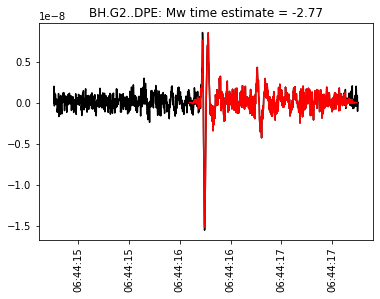

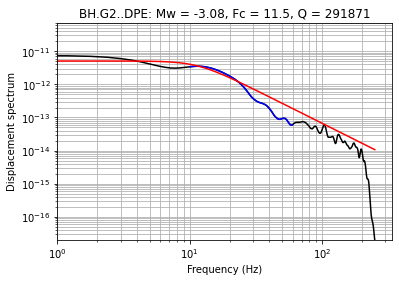

Rejecting spectral estimate with: fc = 11.478982, Q = 291871.984908


BH.G2..DPN
BH.G2..DPZ
station: G14
median r = 452.06


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [5]:
nmagn = [len(ev.station_magnitudes) for ev in catm]
catm_sorted = [ev for _, ev in sorted(zip(nmagn, catm), key=lambda x: x[0], reverse=True)]

for ev in catm_sorted:

    print(ev)
    
    st = get_stream(ev)      
    stations = list(set([p.waveform_id.station_code for p in ev.picks]))
    
    for station in stations:
        print("station: %s" % station)
        magnitude(station, st, ev)

In [ ]:
# for amp in ev.amplitudes:
#     #print(amp)
#     if amp.type == "A":
#         #print(amp)
#         print("\tSNR = %.2f" % amp.snr)
#         print("\t%s" % amp.waveform_id.station_code)
#         #print("\t%s" % amp.time_window)

# for magn in ev.magnitudes:
    
#     print("Magnitude: \n\t Type: %s\n\t Value= %.2f +/ %.2f" % (magn.magnitude_type, magn.mag, magn.mag_errors.uncertainty))

#     for contrib in magn.station_magnitude_contributions:
#         sid = contrib.station_magnitude_id
#         smag = [m for m in ev.station_magnitudes if m.resource_id == sid][0]
#         print(smag.mag)
#         print(smag.comments[-1].text)
#         #for com in smag.comments:
#         #    print("\t%s" % com.text)